In [ ]:
# Experiment loop:
# 1) Train baseline once
# 2) Freeze weights (by copying state_dict)
# 3) Replace ReLU with FT-ReLU
# 4) Sweep one noise type at a time (no cross-interactions since they're worse together)

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

from threeSpiral import (
    make_3_spirals, train, accuracy,
    MLP, FaultTolerantReLU, FTReluConfig, replace_relu_with_ftrelu,
)

device = "cpu"
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)


# Data -------------------------

X, y = make_3_spirals(n_per_class=600, noise=0.25, seed=seed)
idx = np.random.permutation(len(X))
split = int(0.8 * len(X))
tr, te = idx[:split], idx[split:]

train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X[tr]), torch.from_numpy(y[tr])),
    batch_size=256, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X[te]), torch.from_numpy(y[te])),
    batch_size=256, shuffle=False
)


# 1) Train baseline ONCE -------------------------

baseline = MLP(in_dim=2, hidden=32, out_dim=3)
train(baseline, train_loader, test_loader, device, epochs=1000, lr=1e-3)
baseline_acc = accuracy(baseline, test_loader, device)
print(f"\nBaseline test accuracy: {baseline_acc:.4f}")

baseline_state = {k: v.detach().cpu().clone() for k, v in baseline.state_dict().items()}


# FT config (shared) -------------------------

x_min, x_max = -26.0, 14.0
S = 301  # use larger value for final plots; 100 is faster for sweeps

# Define sweeps (edit ranges as you like)
sweeps = {
    "sigma_trig":  [0.0, 0.01, 0.05, 0.10, 0.20, 0.30],
    "sigma_score": [0.0, 0.01, 0.05, 0.10, 0.20, 0.30],
    "p_syn":       [0.0, 0.01, 0.05, 0.10, 0.20, 0.30],
    # sigma_phase is known to be problematic in this architecture; included only as a demonstration
    "sigma_phase": [0.0, 0.01, 0.05, 0.10, 0.20, 0.30],
}

results = {k: [] for k in sweeps.keys()}

def eval_ft_with_noise(noise_name: str, noise_val: float) -> float:
    model = MLP(in_dim=2, hidden=32, out_dim=3)
    model.load_state_dict(baseline_state)

    cfg = FTReluConfig(
        x_min=x_min, x_max=x_max, S=S,
        sigma_phase=0.0,
        sigma_trig=0.0,
        sigma_score=0.0,
        p_syn=0.0,
    )

    # set exactly one noise knob
    setattr(cfg, noise_name, float(noise_val))

    replace_relu_with_ftrelu(model, FaultTolerantReLU(cfg))
    return accuracy(model, test_loader, device)


# 4) Run one-noise-at-a-time sweeps -------------------------

for noise_name, vals in sweeps.items():
    print(f"\n=== Sweeping {noise_name} (others = 0) ===")
    for v in vals:
        acc = eval_ft_with_noise(noise_name, v)
        results[noise_name].append((v, acc))
        print(f"{noise_name}={v:.3e} -> FT acc={acc:.4f} | baseline={baseline_acc:.4f}")

# `results` now contains all sweep data for plotting.
# Example: results["sigma_trig"] = [(0.0, acc0), (0.01, acc1), ...]

epoch    1 | train acc 0.337 | test acc 0.331
epoch  100 | train acc 0.472 | test acc 0.431
epoch  200 | train acc 0.777 | test acc 0.711
epoch  300 | train acc 0.899 | test acc 0.861
epoch  400 | train acc 0.950 | test acc 0.925
epoch  500 | train acc 0.969 | test acc 0.958
epoch  600 | train acc 0.976 | test acc 0.964
epoch  700 | train acc 0.978 | test acc 0.967
epoch  800 | train acc 0.981 | test acc 0.975
epoch  900 | train acc 0.985 | test acc 0.978
epoch 1000 | train acc 0.985 | test acc 0.975

Baseline test accuracy: 0.9750

=== Sweeping sigma_trig (others = 0) ===
sigma_trig=0.000e+00 -> FT acc=0.8833 | baseline=0.9750
sigma_trig=1.000e-02 -> FT acc=0.8861 | baseline=0.9750
sigma_trig=5.000e-02 -> FT acc=0.8417 | baseline=0.9750
sigma_trig=1.000e-01 -> FT acc=0.7222 | baseline=0.9750
sigma_trig=2.000e-01 -> FT acc=0.4694 | baseline=0.9750

=== Sweeping sigma_score (others = 0) ===
sigma_score=0.000e+00 -> FT acc=0.8833 | baseline=0.9750
sigma_score=1.000e-02 -> FT acc=0.8139 |

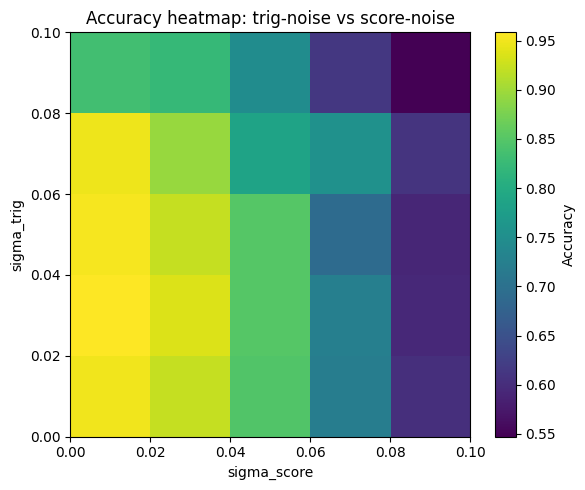

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.imshow(acc_grid, origin="lower", aspect="auto",
           extent=[min(score_vals), max(score_vals), min(trig_vals), max(trig_vals)])
plt.colorbar(label="Accuracy")
plt.xlabel("sigma_score")
plt.ylabel("sigma_trig")
plt.title("Accuracy heatmap: trig-noise vs score-noise")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Baseline reference (computed earlier)
print(f"\nBaseline accuracy (no faults): {baseline_acc:.4f}\n")

probs  = [0.0, 0.01, 0.02, 0.05, 0.1]

acc_grid = np.zeros((len(trig_vals), len(score_vals)))


for j,ss in enumerate(probs):
    model = MLP(in_dim=2, hidden=32, out_dim=3)
    model.load_state_dict(baseline.state_dict())
    cfg = FTReluConfig(
        x_min=-26.0,
        x_max=14.0,
        S=100,
        sigma_phase=0,
        sigma_trig=0,
        sigma_score=0,
        p_syn=ss
    )
    replace_relu_with_ftrelu(model, FaultTolerantReLU(cfg))
    acc = accuracy(model, test_loader, "cpu")
    acc_grid[i, j] = acc
    print(
        f"p_syn={ss:.2f}"
        f"-> FT acc={acc:.3f} | baseline={baseline_acc:.3f}"
    )

NameError: name 'baseline_acc' is not defined

In [ ]:
import numpy as np

# Baseline reference (computed earlier)
print(f"\nBaseline accuracy (no faults): {baseline_acc:.4f}\n")

probs  = [0.0, 0.01, 0.02, 0.05, 0.1]

acc_grid = np.zeros((len(trig_vals), len(score_vals)))


for j,ss in enumerate(probs):
    model = MLP(in_dim=2, hidden=32, out_dim=3)
    model.load_state_dict(baseline.state_dict())
    cfg = FTReluConfig(
        x_min=-26.0,
        x_max=14.0,
        S=100,
        sigma_phase=ss,
        sigma_trig=0,
        sigma_score=0,
        p_syn=0
    )
    replace_relu_with_ftrelu(model, FaultTolerantReLU(cfg))
    acc = accuracy(model, test_loader, "cpu")
    acc_grid[i, j] = acc
    print(
        f"phase={ss:.2f} "
        f"-> FT acc={acc:.3f} | baseline={baseline_acc:.3f}"
    )


Baseline accuracy (no faults): 0.9917

phase=0.00 -> FT acc=0.950 | baseline=0.992
phase=0.01 -> FT acc=0.356 | baseline=0.992
phase=0.02 -> FT acc=0.394 | baseline=0.992
phase=0.05 -> FT acc=0.331 | baseline=0.992
phase=0.10 -> FT acc=0.361 | baseline=0.992


Imported from: /Users/contingency/Desktop/Masters/Information Theory/Untitled/Fault_tolerant_NN/threeSpiral.py

FaultTolerantReLU.forward source:

    @torch.no_grad()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # CPU-only numpy pipeline (evaluation replacement; not for training)
        x_cpu = x.detach().to("cpu")
        x_np = x_cpu.numpy()

        flat = x_np.reshape(-1)
        out = np.empty_like(flat, dtype=np.float32)

        for i in range(flat.shape[0]):
            theta = self._encode_scalar(float(flat[i]))[None, :]  # (1, M)
            res = self.ft.forward(theta)

            if "out_phases" not in res:
                raise KeyError(f"default_arhitecture.forward() did not return 'out_phases'. Keys: {list(res.keys())}")

            out_ph = np.asarray(res["out_phases"], dtype=float).reshape(-1)
            out_ph = out_ph - np.floor(out_ph)  # keep phases in [0,1) for circular decode
            
            y = self._decode_output_scalar(out_ph)
